In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from model import ByteNetLMTime
from dataset import ProteinSequenceDataset, Collater
from losses import D3PMLVBLoss
from utils import Tokenizer
from generate import sample_and_save
from constants import PROTEIN_ALPHABET

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# seed for reproducability
torch.manual_seed(50)

# model parameters
n_tokens = len(PROTEIN_ALPHABET)
d_embed = 8
d_model = 1024
activation = 'gelu'
slim = True
n_layers = 16
kernel_size = 5
r = 128
diffusion_timesteps = 500

# training parameters
num_epochs = 500
batch_size = 128
lr = 1e-4
model = ByteNetLMTime(n_tokens, d_embed, d_model, n_layers, kernel_size, r,
                    activation=activation, slim=slim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
_lambda = 0

# datasets
data_train = ProteinSequenceDataset(train=True)
data_test = ProteinSequenceDataset(train=False)

tokenizer = Tokenizer()
Q_prod, Q_t = tokenizer.q_uniform_schedule(num_steps=diffusion_timesteps)
collater = Collater(tokenizer=tokenizer, num_steps=diffusion_timesteps, Q=Q_t, Q_bar=Q_prod)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, collate_fn=collater)

# loss function
loss_func1 = D3PMLVBLoss(tmax=diffusion_timesteps, tokenizer=tokenizer)
loss_func2 = torch.nn.CrossEntropyLoss(weight=None, reduction='mean')

scaler = GradScaler() if torch.cuda.is_available() else None

In [5]:
print("Number of model parameters: ", count_parameters(model))
print(model)

Number of model parameters:  37878982
ByteNetLMTime(
  (embedder): ByteNetTime(
    (time_encoding): PositionalEncoding1D()
    (embedder): Embedding(22, 8)
    (up_embedder): PositionFeedForward(
      (conv): Conv1d(8, 1024, kernel_size=(1,), stride=(1,))
    )
    (layers): ModuleList(
      (0): ByteNetBlock(
        (conv): MaskedConv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        (sequence1): Sequential(
          (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (1): GELU(approximate='none')
          (2): PositionFeedForward(
            (conv): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
          )
          (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (4): GELU(approximate='none')
        )
        (sequence2): Sequential(
          (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (1): GELU(approximate='none')
          (2): PositionFeedForward(
            (conv): Conv1d(512, 1024, kernel

In [6]:
train_losses = []
test_losses = []

for e in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    train_loss_vals = []
    train_prior_bpd = 0
    for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

        src, src_onehot, timesteps, tgt, tgt_onehot, Q, Q_bar, q, names = batch

        # move to data to device
        q = q.to(device)
        Q = Q.to(device)
        Q_bar = Q_bar.to(device)
        src_onehot = src_onehot.to(device)
        tgt_onehot = tgt_onehot.to(device)
        timesteps = timesteps.to(device)
        src = src.to(device)
        tgt = tgt.to(device)

        # compute number of tokens in batch
        n_tokens = src.shape[0] * src.shape[1]

        optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available(), dtype=torch.float32):
            outputs = model(src, timesteps)
            lvb_loss = loss_func1(src_onehot, q, outputs, tgt, tgt_onehot, timesteps, Q, Q_bar)
            ce_loss = loss_func2(outputs.reshape(-1, outputs.shape[-1]), tgt.reshape(-1))
            lvb_loss = lvb_loss.to(torch.float32)
            ce_loss = ce_loss.to(torch.float32)
            loss = (lvb_loss + (_lambda * ce_loss)) * n_tokens
            nll_loss = ce_loss * n_tokens
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        train_loss += loss.item()
        train_loss_vals.append(loss.item())
    
    train_loss /= batch_idx
    train_losses.append(train_loss_vals)
    
    print("\tEpoch,", e, "complete!", "\tTrain Loss: ", train_loss)
    if e % 10 == 0:
        plt.plot(np.arange(1, e+1), [np.mean(ls) for ls in train_losses], lw=2.5, label='train')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.title('Average training loss per epoch')
        plt.legend()
        plt.show()        

  0%|          | 0/93 [00:00<?, ?it/s]

torch.Size([33664, 22])
torch.Size([33664])


  1%|          | 1/93 [03:44<5:43:36, 224.10s/it]

torch.Size([33664, 22])
torch.Size([33664])


  2%|▏         | 2/93 [08:16<6:23:09, 252.63s/it]

torch.Size([33664, 22])
torch.Size([33664])


  3%|▎         | 3/93 [13:37<6:48:42, 272.47s/it]


KeyboardInterrupt: 

Running /Users/madsfrandsen/Documents/BSc_project/venv/lib/python3.10/site-packages/logomaker/examples/demo_fig1b.py:
-------------------------------------------------------------
# do imports
import matplotlib.pyplot as plt
import logomaker as logomaker

# load crp energy matrix
crp_df = -logomaker.get_example_matrix('crp_energy_matrix',
                                        print_description=False)

# create Logo object
crp_logo = logomaker.Logo(crp_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
cr

<string>:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


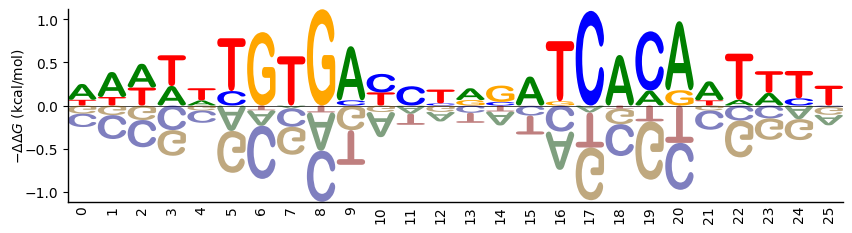

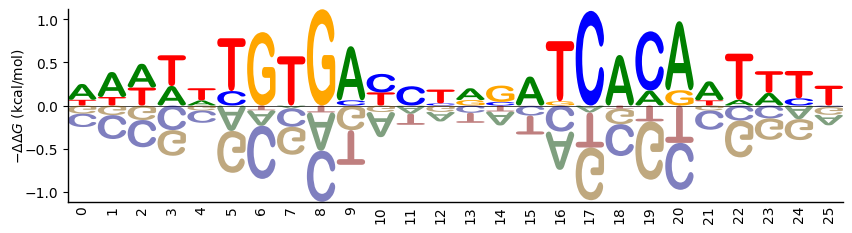

In [11]:
import logomaker as lm
import pandas as pd
lm.demo('fig1b')

In [23]:
gen_sequences_df = pd.read_csv('generated_samples_string.fasta', comment='>', names=['site'])
gen_sequences_df.head()

,site
0,-Y----EFEDLEQEFDARLGVYAMDTGSGAAV-SHRAEERFPICSS...
1,-----DSFAKLEKEFDAKCGVYALDTGTNQTV-SYRSDERFAYAST...
2,-----EDVERHADEAGGTVTACVVD-RSGRTF-SWRADERFYAASV...
3,-----ERIGAVAAQFDGEVGAFVTSLETGEML-DINADACFRAAST...
4,-----DQIAQLEARTGGRLGVAMLDTGSGRRF-AWRGDERFPMCST...


In [24]:
gen_sequences_list = gen_sequences_df['site'].values
gen_sequences_list[:10]

array(['-Y----EFEDLEQEFDARLGVYAMDTGSGAAV-SHRAEERFPICSSFKLLAVAAILKQSQ-QASILNDNITYTRADLEVWSPITEKHVDTGMTIAELSAAALQYSDNAAMNLILQELGGPEGVTAFARSIGDATFRLDRWEPELNSAVPGDERDTSTPLALAESLREFTLGDALPAPERETLVSWLKGNTTGSASIRAGVPANWVVGDKTGAGSYGTANDIAVMWPPNHAPLVLVVLSTRNDKDAKYENKVIAEAAKIVID--',
       '-----DSFAKLEKEFDAKCGVYALDTGTNQTV-SYRSDERFAYASTHKALAVGALLQKKS--LEDLNQRILYSRKDLVNYNPITEKYVDTGMTLKELADASVRYSDNTAQNLILKQLGGPSELKKSLREMGDTVTNPERFEPELNEVHPGDTRDTSSPKAMATTLQSYALGDVLSIEKREFLIDWMKRNTTGDNLIRAGVPKEWEVADKTGSGSYGTRNDIAIIWPPNKKPIVLAILSNHAKEDAKYDDKLIADATKVVL---',
       '-----EDVERHADEAGGTVTACVVD-RSGRTF-SWRADERFYAASVMKVAIYAAVARRAERGRIDTGETWVVPNASVTSGAGSAWERSGAQASLYDLAERMIVVSSNHATNAVLRHVG-LPAVAEIWRRLGARHSAAGHDV----RADGSTSVNNVTARDMARMLGSLARGEAASAASCATMLDVMERQ-VWRRRIASGFPDGTVIAIKSGTVR-GVHHDVGVVEPPDAPPLVIAACTRGERLARPDADRIFAGVSRLV----',
       '-----ERIGAVAAQFDGEVGAFVTSLETGEML-DINADACFRAASTYKMTVLAAAFDAEERGKLDLTEKLTIRSSLVTSSGDVLWSKVGDRFTLGDLTTEMITRSDNTATNVVLGAIG-VDAAMAILQGLGLTQTRVRRGLPGLNE---AEGTNQTTPAELALMLAAVVT

In [25]:
gen_sequences_counts_df = lm.alignment_to_matrix(sequences=gen_sequences_list, to_type='counts',
                                                 characters_to_ignore='.-X')
gen_sequences_counts_df.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,8,0,0
4,0,0,2,24,2,0,0,0,4,0,0,1,0,12,5,1,3,0,0,0


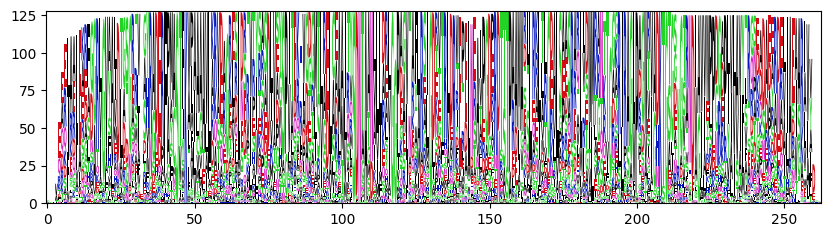

In [26]:
lm.Logo(gen_sequences_counts_df)

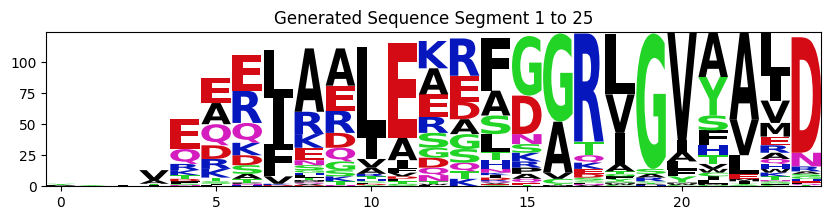

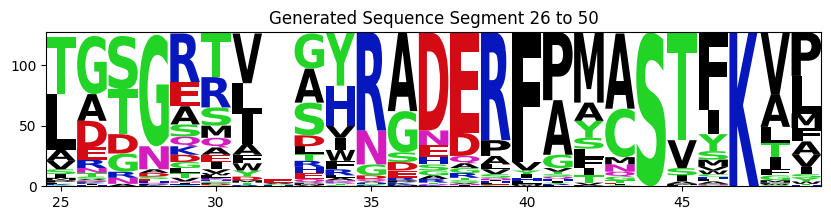

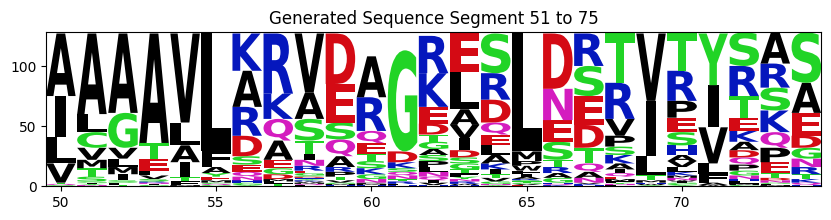

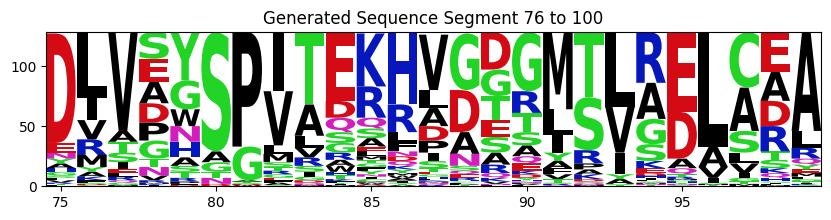

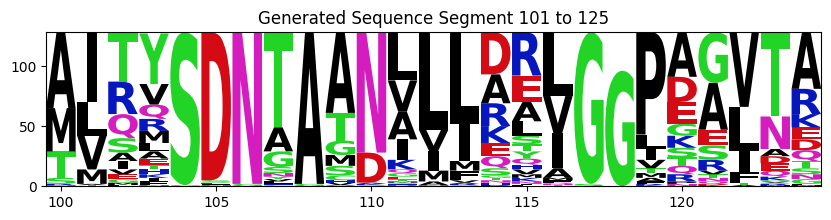

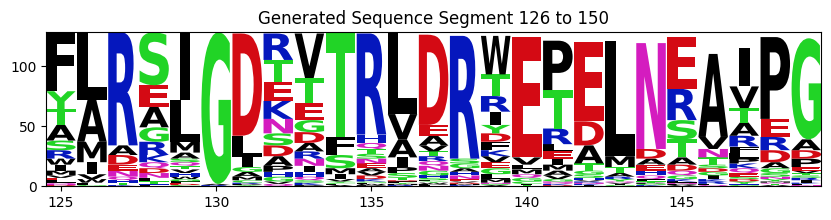

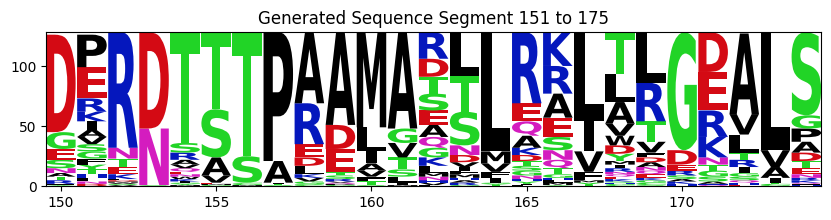

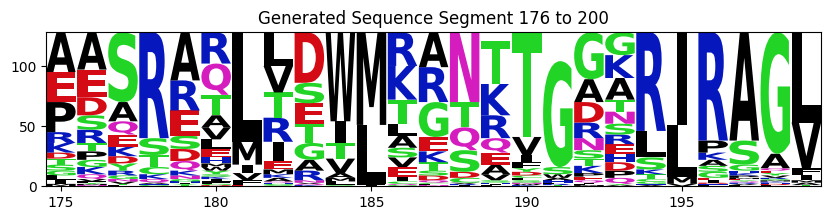

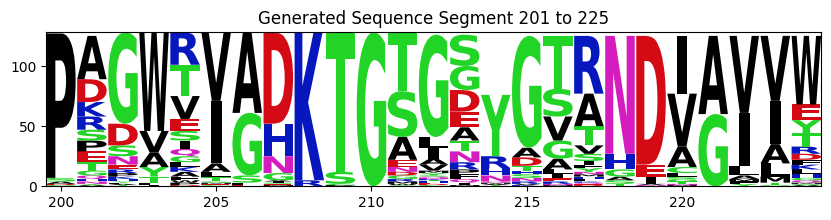

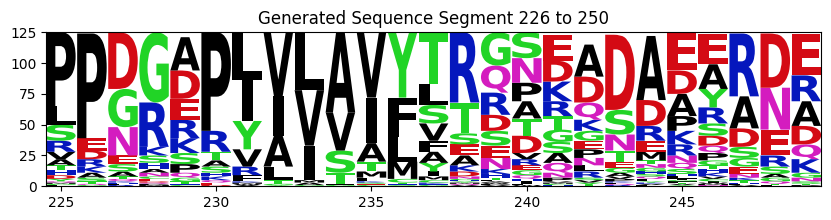

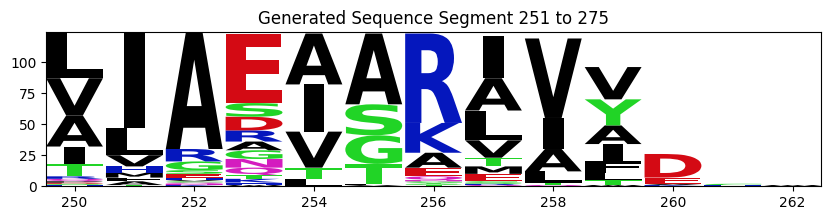

In [33]:
segment_length = 25
for start in range(0, len(gen_sequences_counts_df), segment_length):
    end = start + segment_length
    segment_df = gen_sequences_counts_df.iloc[start:end]
    logo = lm.Logo(segment_df, figsize=(10, 2))
    plt.title(f'Generated Sequence Segment {start+1} to {end}')
    plt.show()

In [31]:
train_data_counts_df = lm.alignment_to_matrix(sequences=data_train.data, to_type='counts',
                                              characters_to_ignore='.-X')
train_data_counts_df.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,415,0,0,0,0,0,0,146,0,2,1,0,0,0,0,0,23,505,0,0
4,179,0,286,1051,0,0,282,0,296,1,0,223,0,1142,240,99,200,0,0,0


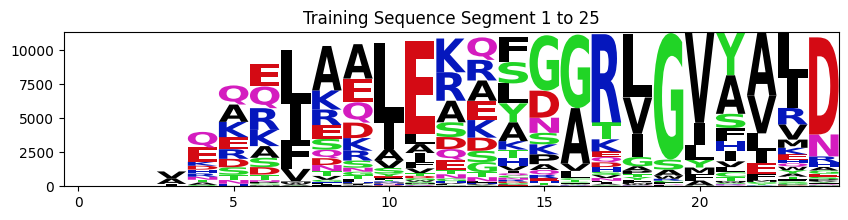

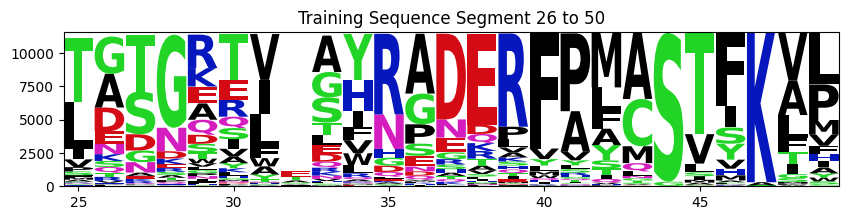

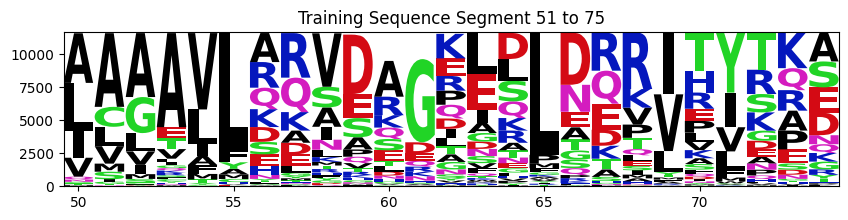

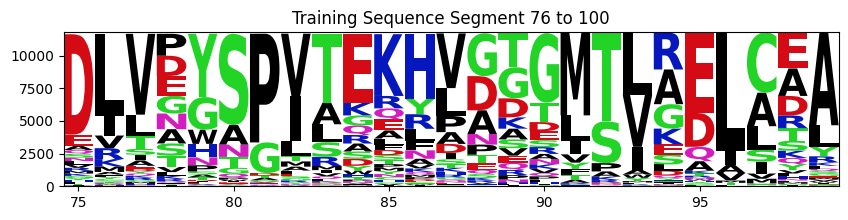

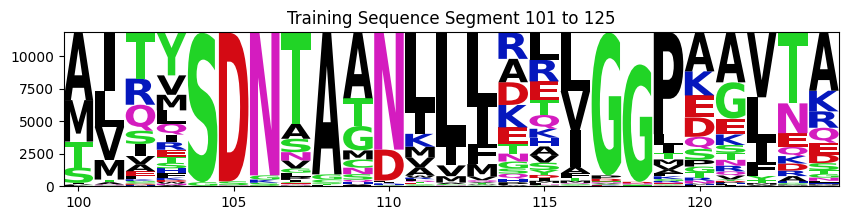

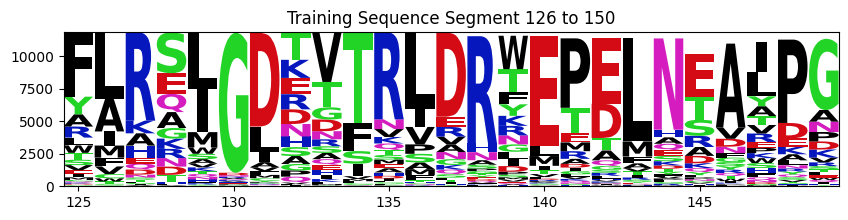

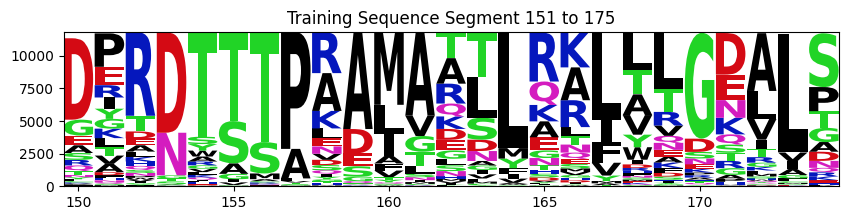

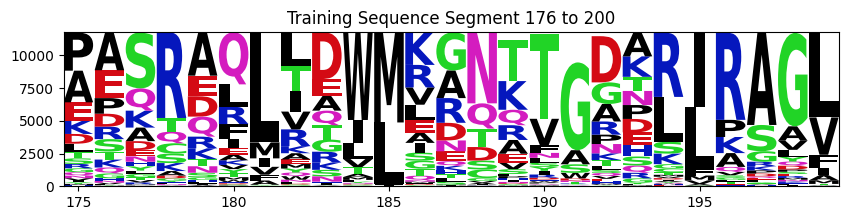

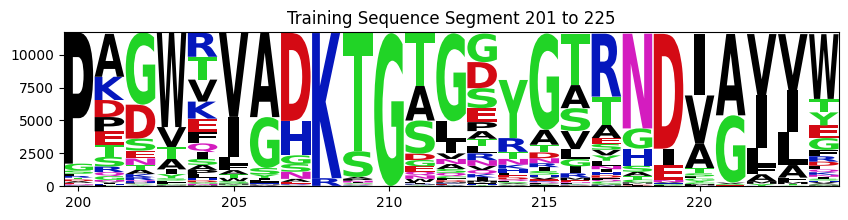

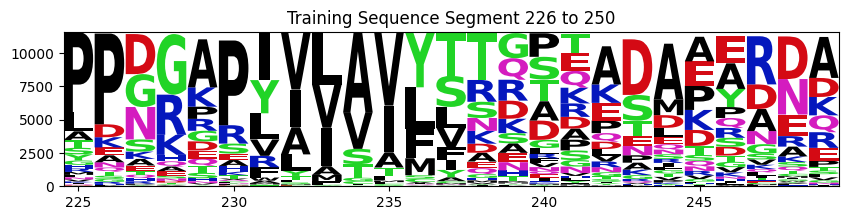

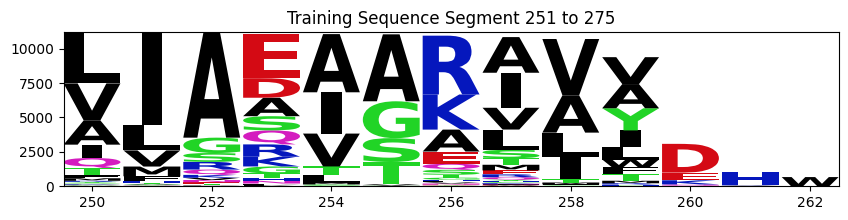

In [34]:
segment_length = 25
for start in range(0, len(train_data_counts_df), segment_length):
    end = start + segment_length
    segment_df = train_data_counts_df.iloc[start:end]
    logo = lm.Logo(segment_df, figsize=(10, 2))
    plt.title(f'Training Sequence Segment {start+1} to {end}')
    plt.show()